In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
# MINIST 데이터셋 준비 및 DataLoader 설정

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(28),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])
                   ])),
    batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.28MB/s]


In [9]:
# Generator 네트워크 정의 (생성기)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

In [10]:
# Discriminator 네트워크 정의 (판별기)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [12]:
# 장치 설정(GPU 사용가능하면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 생성기와 판별기 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 옵티마이저 설정
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 손실함수
criterion = nn.BCELoss()
num_epochs = 50

# 평가를 위해 고정된 노이즈 벡터 발생
fixed_noise = torch.randn(64, 100, device=device)

# 결과 저장을 위한 폴더 생성
os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# GAN 학습 루프 (에포크 단위)
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_D_loss = 0.0
    total_G_loss = 0.0
    total_real_score = 0.0
    total_fake_score = 0.0
    num_batches = 0

    for real_images, _ in dataloader:
        num_batches += 1
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 판별기 학습
        discriminator.zero_grad()
        outputs_real = discriminator(real_images.to(device))
        d_loss_real = criterion(outputs_real, real_labels)
        real_score = outputs_real.mean().item()

        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        fake_score = outputs_fake.mean().item()

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optim_D.step()

        # 생성기 학습 (별도 노이즈 샘플 사용)
        generator.zero_grad()
        noise2 = torch.randn(batch_size, 100, device=device)
        fake_images2 = generator(noise2)
        outputs = discriminator(fake_images2)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optim_G.step()

        total_D_loss += d_loss.item()
        total_G_loss += g_loss.item()
        total_real_score += real_score
        total_fake_score += fake_score

    # 에폭당 평균 값 계산 후 출력
    avg_d_loss = total_D_loss / num_batches             # 판별자 손실 값
    avg_g_loss = total_G_loss / num_batches             # 생성자 손실 값
    avg_real_score = total_real_score / num_batches     # 실제 이미지에 대해 판별자가 출력한 평균 '진짜일 확률'
    avg_fake_score = total_fake_score / num_batches     # 가짜 이미지에 대해 판별자가 출력한 평균 '진짜일 확률'

    print(f'Epoch [{epoch+1}/{num_epochs}]: d_loss={avg_d_loss:.4f}, g_loss={avg_g_loss:.4f}, '
            f'D(x)={avg_real_score:.2f}, D(G(z))={avg_fake_score:.2f}')

    # 평가 단계 : 고정 노이즈를 사용해 생성된 이미지와 판별기 결과 저장
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        save_image(fake_images, f'./images/fake_images_epoch_{epoch+1:04d}.png', normalize=True)
        discriminator_outputs = discriminator(fake_images).cpu().detach().numpy().reshape(8, 8)
        np.save(f'./results/discriminator_outputs_epoch_{epoch+1:04d}.npy', discriminator_outputs)

print('Training finished.')

Epoch [1/50]: d_loss=0.7560, g_loss=2.3653, D(x)=0.80, D(G(z))=0.31
Epoch [2/50]: d_loss=0.5889, g_loss=2.9387, D(x)=0.82, D(G(z))=0.19
Epoch [3/50]: d_loss=0.4625, g_loss=2.8896, D(x)=0.86, D(G(z))=0.14
Epoch [4/50]: d_loss=0.5392, g_loss=2.4364, D(x)=0.84, D(G(z))=0.17
Epoch [5/50]: d_loss=0.7606, g_loss=1.8495, D(x)=0.76, D(G(z))=0.25
Epoch [6/50]: d_loss=0.8216, g_loss=1.6999, D(x)=0.73, D(G(z))=0.27
Epoch [7/50]: d_loss=0.8790, g_loss=1.5917, D(x)=0.71, D(G(z))=0.29
Epoch [8/50]: d_loss=0.9206, g_loss=1.4886, D(x)=0.70, D(G(z))=0.31
Epoch [9/50]: d_loss=0.9505, g_loss=1.4179, D(x)=0.69, D(G(z))=0.32
Epoch [10/50]: d_loss=1.0024, g_loss=1.3329, D(x)=0.67, D(G(z))=0.34
Epoch [11/50]: d_loss=1.0540, g_loss=1.2472, D(x)=0.65, D(G(z))=0.36
Epoch [12/50]: d_loss=1.0597, g_loss=1.2391, D(x)=0.64, D(G(z))=0.36
Epoch [13/50]: d_loss=1.0785, g_loss=1.2022, D(x)=0.64, D(G(z))=0.37
Epoch [14/50]: d_loss=1.0872, g_loss=1.1930, D(x)=0.63, D(G(z))=0.37
Epoch [15/50]: d_loss=1.0985, g_loss=1.1647

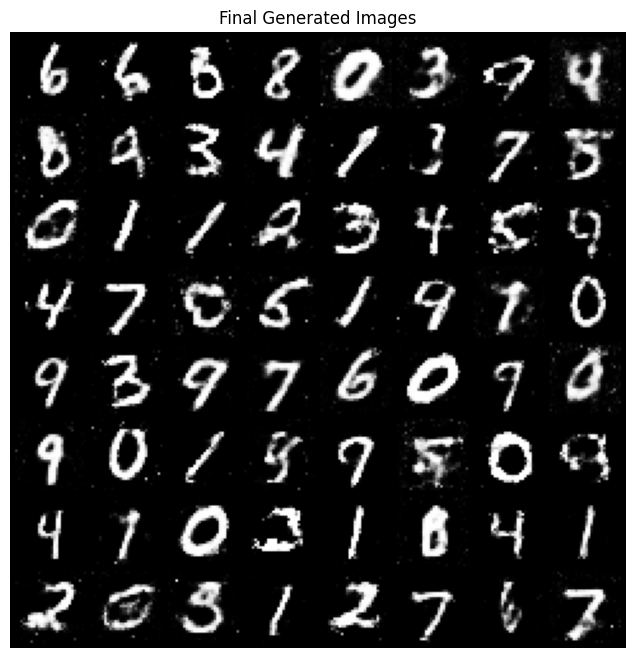

In [13]:
# 마지막 에포크에서 생성된 이미지 그리드 출력

with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()
grid = utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title('Final Generated Images')
plt.axis('off')
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

# MNIST 데이터셋 사용
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (MNIST는 0~9 숫자)
idx_to_class = {i: str(i) for i in range(10)}
print(idx_to_class)

image_size = 28      # MNIST 이미지 크기
num_classes = 10     # 10개 클래스 (0~9)
latent_dim = 100     # 잠재 공간 차원

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.24MB/s]

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [16]:
# 생성자
class cGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)         # 10*10 like one-hot

        self.init_size = image_size // 4        # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsmale(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [17]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

In [18]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 학습 루프 (에포크마다 D(x)와 D(G(z)) 평균 점수 계산)
for epoch in range(epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        total_samples += batch_size_current
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        # 실제 이미지에 대한 판별자 출력
        real_pred = discriminator(imgs, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels  # (여기서는 입력된 라벨 사용)
        gen_imgs = generator(noise, gen_labels)
        # 가짜 이미지에 대한 판별자 출력
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        running_d_loss += d_loss.item() * batch_size_current
        running_g_loss += g_loss.item() * batch_size_current

    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}  D(x): {avg_d_x:.2f}  D(G(z)): {avg_d_gz:.2f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples_vis = n_row * n_col
        noise = torch.randn(total_samples_vis, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        with torch.no_grad():
            gen_imgs = generator(noise, labels_sample)
            disc_out = discriminator(gen_imgs, labels_sample)
        gen_imgs = gen_imgs.detach().cpu().numpy()
        disc_out = disc_out.detach().cpu().numpy()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                score = disc_out[idx, 0]
                axs[i, j].set_title(f"Label: {labels_sample[idx].item()}\nD: {score:.2f}", fontsize=8)
        plt.tight_layout()
        plt.show()
        generator.train()

TypeError: Generator.forward() takes 2 positional arguments but 3 were given